In [1]:
#import packages
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from keras.regularizers import l2

In [2]:
# load train and test dataset
def load_dataset():
	# load dataset
	(x_train, y_train), (x_test, y_test) = cifar10.load_data()
	
	y_train = to_categorical(y_train)
	y_test = to_categorical(y_test)
	return x_train, y_train, x_test, y_test

In [3]:
# Preprocessing and normailzation
def normalization(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')
  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0
  # return normalized images
  return train_norm, test_norm

In [4]:
# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))	
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))
  # compile model
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [5]:
# load dataset
x_train, y_train, x_test, y_test = load_dataset()
# prepare pixel data
x_train, x_test = normalization(x_train, x_test)
# define model
model = define_model()
# fit model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test), verbose=0)

170508288/170498071 [==============================] - 6s 0us/step


In [6]:
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
test_acc

0.8256000280380249

In [7]:
def bagging_predictions(members, x_test):
	# make predictions
	y_pred = [model.predict(x_test) for model in members]
	y_pred = array(y_pred)
	# sum across ensemble members
	summed = numpy.sum(y_pred, axis=0)
	# argmax across classes
	result = argmax(summed, axis=1)
	return result

In [8]:
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, x_test, y_test):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = bagging_predictions(subset, x_test)
	# calculate accuracy
	return accuracy_score(y_test, yhat)

In [9]:
from sklearn.utils import resample
from sklearn.datasets import make_blobs
import time

start = time.time()

X=x_train
y=y_train
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
	# select indexes
	ix = [i for i in range(len(X))]
	train_ix = resample(ix, replace=True, n_samples=4500)
	test_ix = [x for x in ix if x not in train_ix]
	# select data
	trainX, trainy = X[train_ix], y[train_ix]
	testX, testy = X[test_ix], y[test_ix]
	# evaluate model
	#history = model.fit(trainX, trainy, epochs=5, batch_size=64, validation_data=(testX, testy), verbose=0)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)
history = model.fit(trainX, trainy, epochs=100, batch_size=64, validation_data=(testX, testy), verbose=0)
print("Total time: ", time.time() - start, "seconds")

>0.826
>0.826
>0.826
>0.826
>0.826
>0.826
>0.826
>0.826
>0.826
>0.826
Total time:  303.54602456092834 seconds


Test loss: 0.15200410783290863
Test accuracy: 0.9497221112251282
Training loss: 0.0005003992118872702
Training accuracy: 1.0


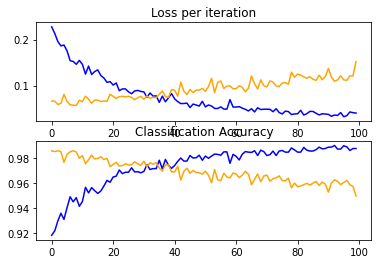

In [10]:
scores = model.evaluate(testX, testy, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
score = model.evaluate(trainX, trainy, verbose=0)
print('Training loss:', score[0])
print('Training accuracy:', score[1])
# plot loss
pyplot.subplot(211)
pyplot.title('Loss per iteration')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

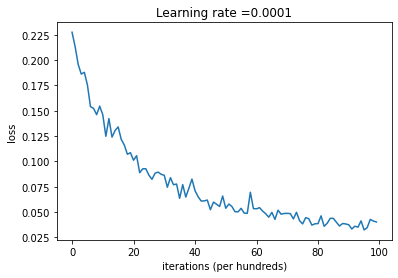

In [11]:
# plot learning curves 
from matplotlib import pyplot
import matplotlib.pyplot as plt
pyplot.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(.0001))
plt.show()

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = model.predict(testX)
y_pred=np.argmax(y_pred,axis=1)
y_test=np.argmax(testy,axis=1)
y_pred.shape


(45706,)

In [13]:
y_test.shape

(45706,)

In [14]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4576
           1       0.99      0.99      0.99      4578
           2       0.97      0.90      0.94      4597
           3       0.90      0.89      0.90      4550
           4       0.91      0.97      0.94      4534
           5       0.95      0.87      0.91      4569
           6       0.91      0.99      0.94      4553
           7       0.99      0.95      0.97      4610
           8       0.95      1.00      0.97      4573
           9       0.98      0.98      0.98      4566

    accuracy                           0.95     45706
   macro avg       0.95      0.95      0.95     45706
weighted avg       0.95      0.95      0.95     45706

